# Analysis of the Correlation Between Construction Events and Noise Complaints

In [1]:
%matplotlib inline

import csv
import ast
import itertools
import numpy
import sys
import collections
import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import shape, Point
from rtree import index
import time
from datetime import datetime, date, timedelta
from multiprocessing import Pool
from haversine import haversine

csv.field_size_limit(sys.maxsize)

complaints = {'Alarms':[], 'Banging/Pounding':[], 'Car/Truck Horn':[], 'Construction Equipment':[],
              'Construction Before/After Hours':[], 'Jack Hammering':[], 'Engine Idling':[]}

permiters = {'ALTERATION':[], 'PLUMBING':[], 'EQUIPMENT WORK':[], 'EQUIPMENT':[], 'FOUNDATION':[], 
             'NEW BUILDING':[], 'SIGN':[], 'FULL DEMOLITION':[]}

######################### UTILS #########################    
def roundTime(dt=None, roundTo=60):
   """
   Round a datetime object to any time laps in seconds
   :param dt: datetime.datetime object, default now.
   :param roundTo: closest number of seconds to round to, default 1 minute.
   :return: the rounded time.
   """
   if dt == None : dt = datetime.now()
   seconds = (dt - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0, rounding-seconds, -dt.microsecond)

def filteredCsvToDict(filename, fields, location):
    dict = {}
    with open(filename, 'rb') as fin:
        reader = csv.reader(fin, delimiter=';')
        for row in reader:
            key = row[0]
            new_values = []
            for item in ast.literal_eval(row[1]):
                match = [field for field in fields.keys() if field in item[3]]   
                if match:
                    new_values.append(item)
                    fields[match[0]].append(item)
            dict[key] = new_values
    return dict

In [2]:
permiters_per_region = filteredCsvToDict("../Resources/Permiters_Per_Region.csv", permiters, 3)
complaints_per_region = filteredCsvToDict("../Resources/Complaints_Per_Region.csv", complaints, 3)

# General Visualization

## Number of Complaints per Category

Total number of complaints: 55196
Alarms : 3649
Banging/Pounding : 4860
Car/Truck Horn : 4432
Construction Before/After Hours : 27264
Construction Equipment : 6991
Engine Idling : 5254
Jack Hammering : 2746


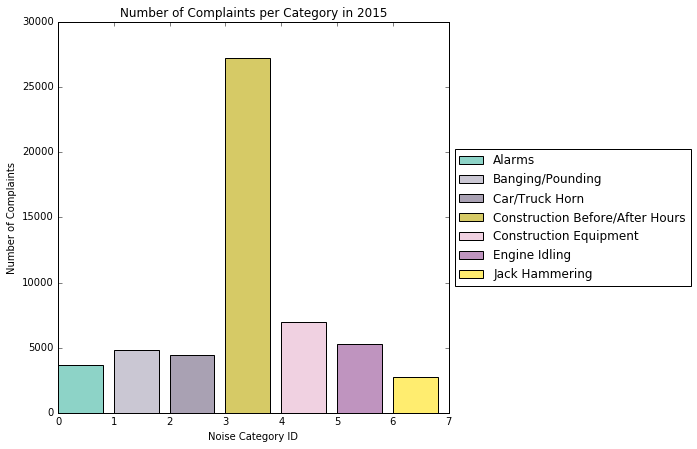

In [3]:
cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in numpy.linspace(0, 1, len(complaints))]
complaints = collections.OrderedDict(sorted(complaints.items()))

plt.figure(figsize=(7, 7), dpi=200)
item = 0
for key, value in complaints.iteritems():
    plt.bar(item, len(value), label=key, color=colors[item])
    item += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.xlabel('Noise Category ID')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Category in 2015')

print 'Total number of complaints:', sum(len(value) for value in complaints.values())
for key, value in complaints.iteritems():
    print key, ':', len(value)

## Number of Complaints per Region

(0, 149)

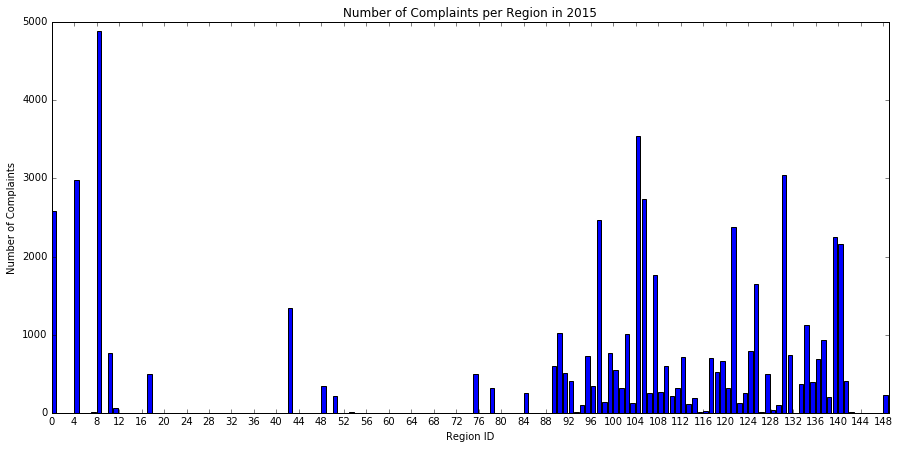

In [4]:
plt.figure(figsize=(15, 7), dpi=200)
for key, value in complaints_per_region.iteritems():
    plt.bar(int(key), len(value), label=int(key)) 
plt.xticks(numpy.arange(0, 149, 4))
plt.xlabel('Region ID')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints per Region in 2015')
plt.xlim(0, 149)

In [5]:
top_noisy = collections.OrderedDict(sorted(complaints_per_region.items(), key=lambda x:len(x[1]), reverse=True))
top_noisy = itertools.islice(top_noisy.items(), 0, 5)

for key, value in top_noisy:
    print 'Region', key, ':', len(value)

Region 8 : 4887
Region 104 : 3538
Region 130 : 3046
Region 4 : 2974
Region 105 : 2734


## Number of Permiters per Category

Total number of permiters: 144967
ALTERATION : 10793
EQUIPMENT : 89487
EQUIPMENT WORK : 0
FOUNDATION : 4522
FULL DEMOLITION : 1921
NEW BUILDING : 4129
PLUMBING : 31876
SIGN : 2239


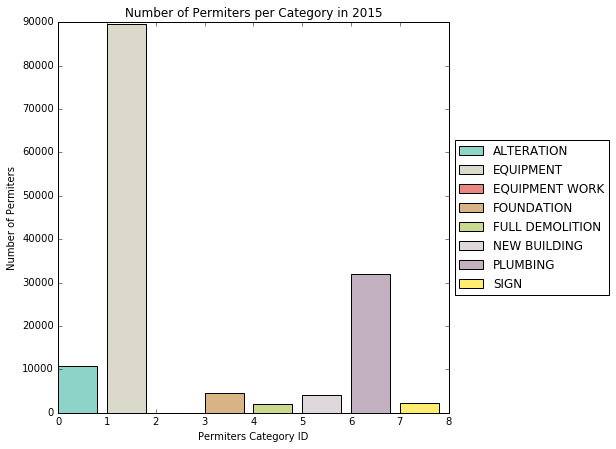

In [6]:
colors = [cmap(i) for i in numpy.linspace(0, 1, len(permiters))]
permiters = collections.OrderedDict(sorted(permiters.items()))

plt.figure(figsize=(7, 7), dpi=200)
item = 0
for key, value in permiters.iteritems():
    plt.bar(item, len(value), label=key, color=colors[item])
    item += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.xlabel('Permiters Category ID')
plt.ylabel('Number of Permiters')
plt.title('Number of Permiters per Category in 2015')

print 'Total number of permiters:', sum(len(value) for value in permiters.values())
for key, value in permiters.iteritems():
    print key, ':', len(value)

## Number of Permiters per Region

(0, 149)

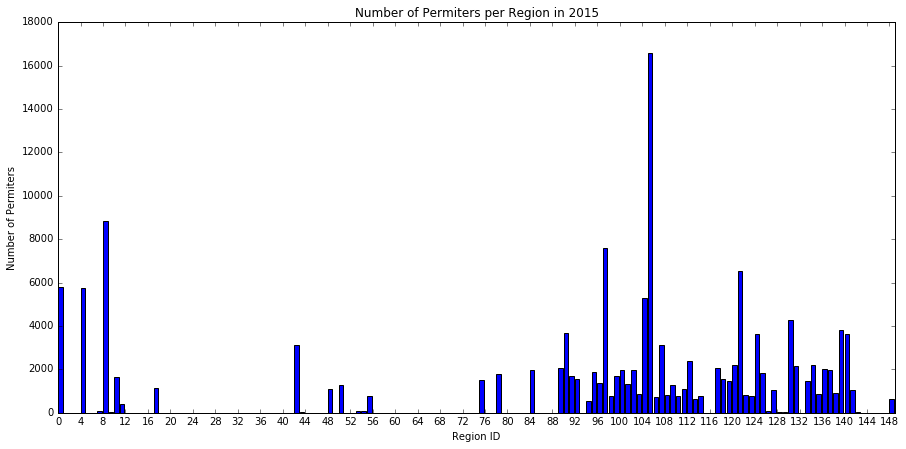

In [7]:
plt.figure(figsize=(15, 7), dpi=200)
for key, value in permiters_per_region.iteritems():
    plt.bar(int(key), len(value), label=int(key)) 
plt.xticks(numpy.arange(0, 149, 4))
plt.xlabel('Region ID')
plt.ylabel('Number of Permiters')
plt.title('Number of Permiters per Region in 2015')
plt.xlim(0, 149)

In [8]:
top_noisy = collections.OrderedDict(sorted(permiters_per_region.items(), key=lambda x:len(x[1]), reverse=True))
top_noisy = itertools.islice(top_noisy.items(), 0, 5)

for key, value in top_noisy:
    print 'Region', key, ':', len(value)

Region 105 : 16595
Region 8 : 8825
Region 97 : 7585
Region 121 : 6556
Region 0 : 5794


## Filtering by Time

In [9]:
def get_complaints_by_time(data_by_type):
    """
    Given a dictionary which values contains information about time, creates a new
    data based on the dates of the previous one.
    :param data_by_type: a dictionary of {key : value}.
    :return: a matrix of 366 x len(data_by_type) and a dictionary {data : values}.
    """
    data_by_day_and_type = numpy.zeros((len(data_by_type), 366)) 
    data_by_day = {}
    
    for i in range(366):
        data_by_day[i] = []
                                    
    index = 0
    for key, value in data_by_type.iteritems():
        for item in value:
            time = roundTime(datetime.strptime(item[2], '%m/%d/%Y %I:%M:%S %p'), roundTo=60 * 60)
            day_of_year = time.timetuple().tm_yday

            data_by_day_and_type[index, day_of_year-1] += 1
            data_by_day[day_of_year-1].append((item[0], item[1], key))
            
        index += 1
        
    return data_by_day_and_type, data_by_day

In [10]:
complaints_matrix, complaints_dict = get_complaints_by_time(complaints)

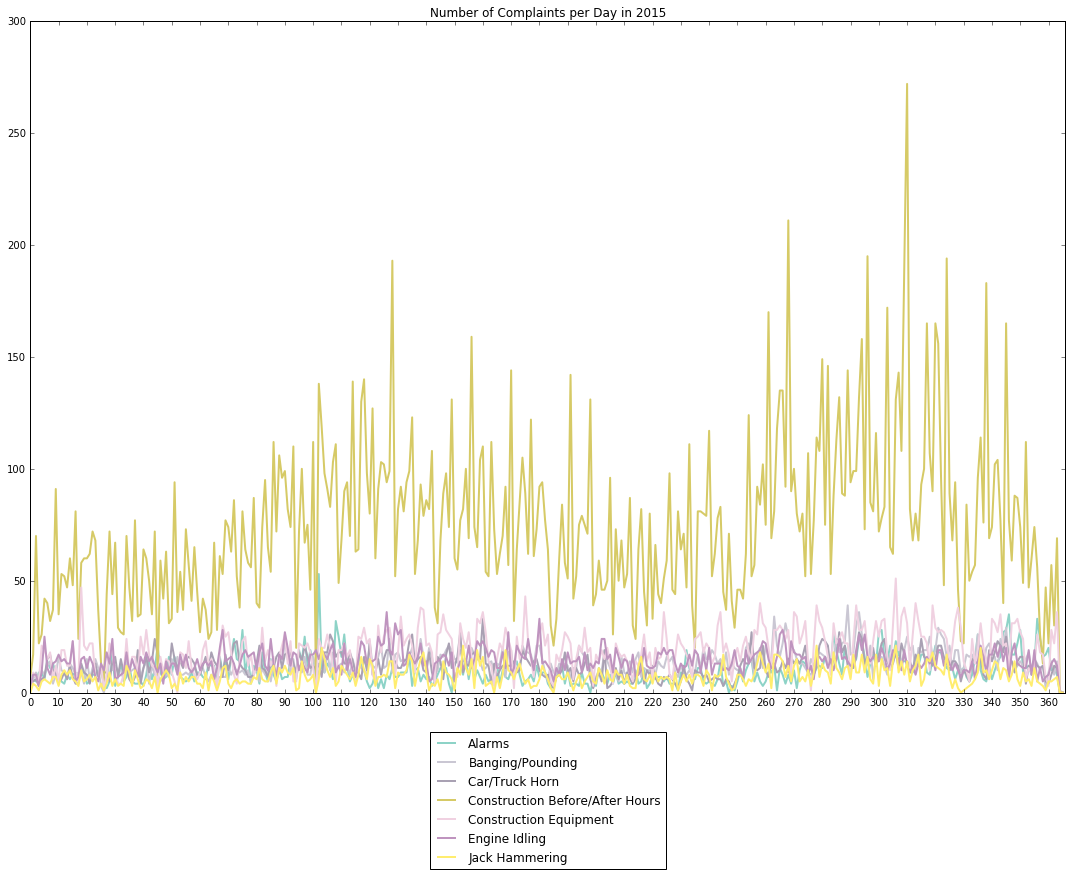

In [11]:
y = range(complaints_matrix.shape[1])

colors = [cmap(i) for i in numpy.linspace(0, 1, len(complaints))]
keys = complaints.keys()

plt.figure(figsize=(15, 10))
for i in range(complaints_matrix.shape[0]):
    plt.plot(y, complaints_matrix[i,:], label=keys[i], color=colors[i], linewidth=2)

plt.title('Number of Complaints per Day in 2015')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
plt.xticks(numpy.arange(0, 366, 10))
plt.xlim(0, 366)
plt.tight_layout()

In [12]:
def get_permiters_by_time(data_by_type):
    """
    Given a dictionary which values contains information about time, creates a new
    data based on the dates of the previous one.
    :param data_by_type: a dictionary of {key : value}.
    :return: a matrix of 366 x len(data_by_type) and a dictionary {data : values}.
    """
    data_by_day_and_type = numpy.zeros((len(data_by_type), 366)) 
    data_by_day = {}
    
    for i in range(366):
        data_by_day[i] = []
                                    
    index = 0
    for key, value in data_by_type.iteritems():
        for item in value:
            ini_time = roundTime(datetime.strptime(item[2], '%m/%d/%Y %H:%M:%S'), roundTo=60 * 60)
            end_time = roundTime(datetime.strptime(item[4], '%m/%d/%Y %H:%M:%S'), roundTo=60 * 60)
            ini_day_of_year = ini_time.timetuple().tm_yday
            end_day_of_year = end_time.timetuple().tm_yday
            
            for day in range(ini_day_of_year, end_day_of_year+1):
                data_by_day_and_type[index, day-1] += 1
                data_by_day[day-1].append((item[0], item[1], key))
            
        index += 1
        
    return data_by_day_and_type, data_by_day

In [13]:
permiters_matrix, permiters_dict = get_permiters_by_time(permiters)

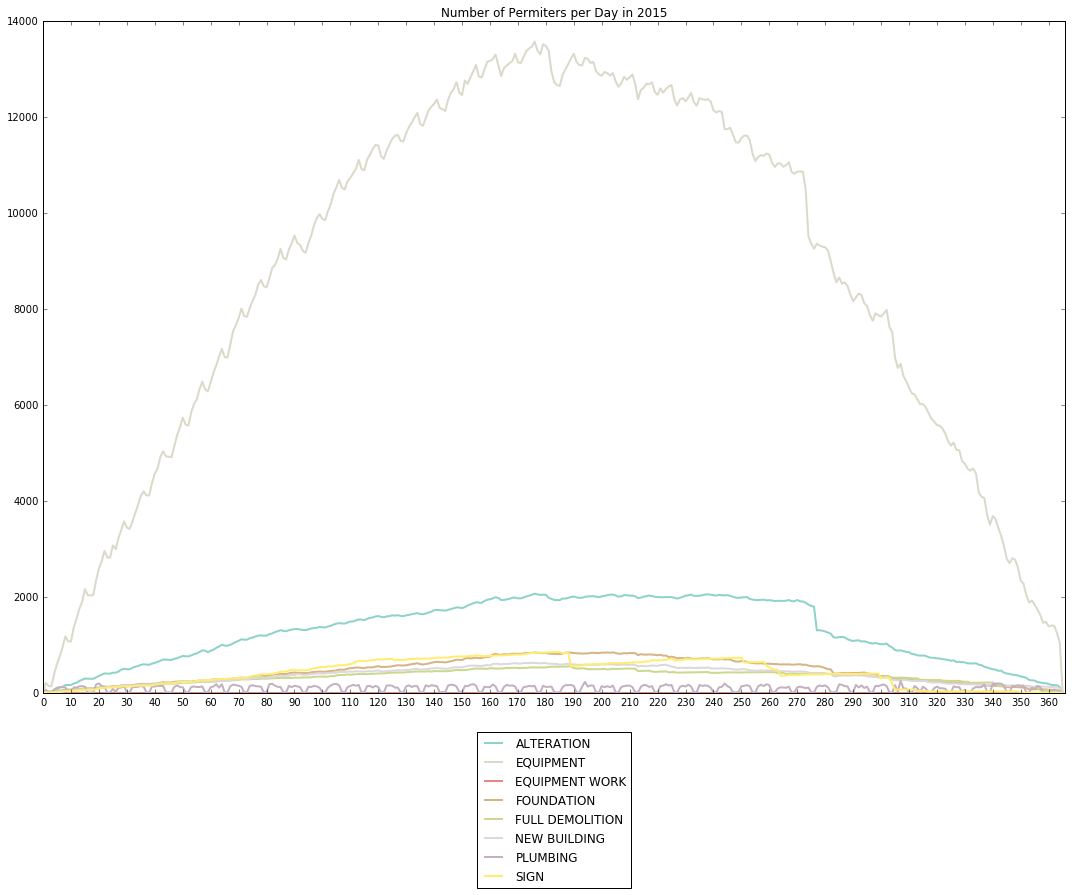

In [14]:
y = range(permiters_matrix.shape[1])

colors = [cmap(i) for i in numpy.linspace(0, 1, len(permiters))]
keys = permiters.keys()

plt.figure(figsize=(15, 10))
for i in range(permiters_matrix.shape[0]):
    plt.plot(y, permiters_matrix[i,:], label=keys[i], color=colors[i], linewidth=2)

plt.title('Number of Permiters per Day in 2015')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
plt.xticks(numpy.arange(0, 366, 10))
plt.xlim(0, 366)
plt.tight_layout()

## Permiters vs Complaints Categories Correlation

Given:
- A set complaint $\in \mathsf{Comp}$.
- A set of permiters $\in \mathsf{Perm}$.

For a 311 complaint $n_s$ (of the $i$ th category), we count the permiters $\phi_j$ (of a category $j$ within the distance $\delta$ to $n_s$.

Then the correlation between two categories $comp\_i$ and $comp\_j$ can be calculated as:

$$cor(comp\_i,comp\_j) = \frac{\sum n_s \mid \phi_j \mid}{\mid comp\_i \mid \cdot \mid comp\_j \mid}$$
 
$$\phi_j=n'_s \mid dist(n_s,n'_s) \leq \delta \wedge n'_s.c = comp\_j$$

In [15]:
def calculate_correlation(data_1, data_2, dist):
    """
    Fill the correlation matrix between data_1 and data_2
    :param data_1: dictionary {key : [coordinates]}
    :param data_2: dictionary {key : [coordinates]}
    :param dist: minimum distance between coordinates to be considered, in kilometers.
    :return: numpy array containing the correlation between each complaint category.
    """
    pool = Pool()
    results = []

    data_1 = collections.OrderedDict(sorted(data_1.items()))
    data_2 = collections.OrderedDict(sorted(data_2.items()))
    data_1_size = len(data_1)                                          
    data_2_size = len(data_2)

    corr = numpy.zeros((data_1_size, data_2_size))
    
    for index_1, key_1 in enumerate(data_1):
        for index_2, key_2 in enumerate(data_2):  # Forming pairs
            type_1 = data_1[key_1]  # List of data in data_1 of type *i*
            type_2 = data_2[key_2]  # List of data in data_2 of type *j*
            result = pool.apply_async(correlation, args=[type_1, type_2, dist])
            results.append((result, index_1, index_2))
    
    for result, index_1, index_2 in results:
        corr[index_1, index_2] = result.get()
    pool.close()
    pool.join()
    
    return corr
    
    
def correlation(type_1, type_2, dist):
    total = float(len(type_1) * len(type_2))
    if total > 0:
        in_range = 0.0
        for l1 in type_1:      # Coordinates of a data in data_1
            for l2 in type_2:  # Coordinates of a data in data_2
                p1 = (float(l1[0]), float(l1[1]))
                p2 = (float(l2[0]), float(l2[1]))
                if haversine(p1, p2) <= dist:    # Distance between two data of types *i* and *j*
                    in_range += 1.0              # Number of data in data_2 inside area of data in data_1
        return in_range / total  # Correlation between category *i* and *j*
    return 0.0

In [16]:
def data_for_interval(date_ini, date_end, date_dict, keys):
    dict = {}
    for key in keys:
        dict[key] = []
        
    ini_day_of_year = date_ini.timetuple().tm_yday-1
    end_day_of_year = date_end.timetuple().tm_yday-1
    
    for day in range(ini_day_of_year, end_day_of_year+1):
        day_data = date_dict[day]
        for item in day_data:  # list of data (long, lat, desc)
            dict[item[2]].append((item[0], item[1]))
    
    return dict

In [17]:
date_ini = datetime(2015, 01, 01)
date_end = datetime(2015, 01, 31)

new_complaints = data_for_interval(date_ini, date_end, complaints_dict, complaints.keys())
new_permiters  = data_for_interval(date_ini, date_end, permiters_dict, permiters.keys())

new_complaints = collections.OrderedDict(sorted(new_complaints.items()))
new_permiters = collections.OrderedDict(sorted(new_permiters.items()))

print 'Number of complains considered:', sum(len(value) for value in new_complaints.values())
print 'Number of permits considered:', sum(len(value) for value in new_permiters.values())

Number of complains considered: 3196
Number of permits considered: 76403


In [18]:
for key, value in new_complaints.iteritems():
    print key, ':', len(value)    

Alarms : 241
Banging/Pounding : 276
Car/Truck Horn : 263
Construction Before/After Hours : 1443
Construction Equipment : 433
Engine Idling : 376
Jack Hammering : 164


In [19]:
for key, value in new_permiters.iteritems():
    print key, ':', len(value)   

ALTERATION : 7960
EQUIPMENT : 57276
EQUIPMENT WORK : 0
FOUNDATION : 2544
FULL DEMOLITION : 2303
NEW BUILDING : 2196
PLUMBING : 2250
SIGN : 1874


In [20]:
start_time = time.time()
corr = calculate_correlation(new_permiters, new_complaints, 20)
print 'Time to calculate correlation', (time.time() - start_time)/60.0

Time to calculate correlation 4.30749604702


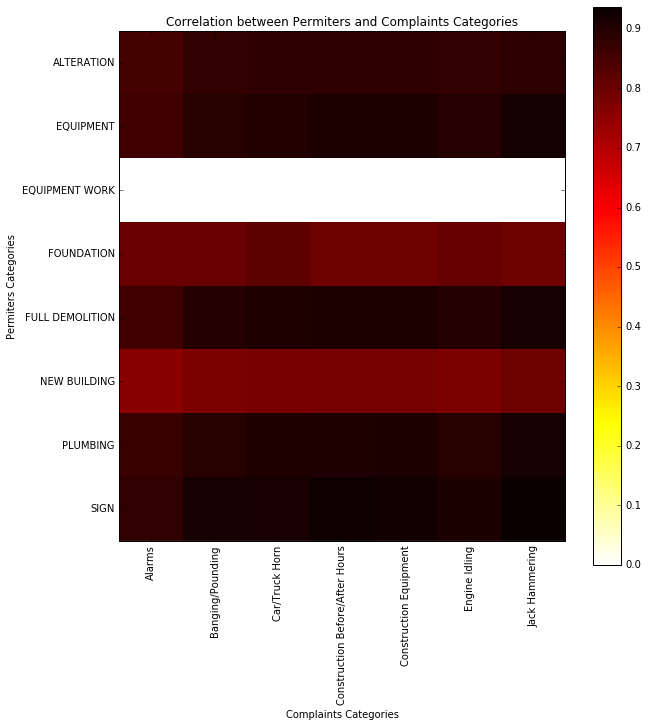

In [21]:
plt.figure(figsize=(10, 10), dpi=200)
fig = plt.imshow(corr, cmap=plt.cm.hot_r, interpolation='none')
plt.axes().set_aspect('equal')
plt.colorbar(fig)
plt.xlabel('Complaints Categories')
plt.xticks(range(len(complaints)), complaints.keys(), rotation='vertical')
plt.ylabel('Permiters Categories')
plt.yticks(range(len(permiters)), permiters.keys())
plt.title('Correlation between Permiters and Complaints Categories')